# Analysis of goalkeeper's kickouts.
*Imagine that you're a data analytist of your favourite football team and you were requested to help your manager to prepare for next season.*

The research below provides **data of goalkeeper's kickouts from previous matches to check if the ball was passed to our team player or took by opposite team.** The objective is to analyze the data to gain insights about our team performance in that particular case.

In [127]:
import csv
import numpy as np
import matplotlib.pyplot as plt

## 1. Dataset
The dataset consists of X and Y coordinates of kickouts and information whether it was passed to our team or captured by rival.

### 1.1 Load the dataset
**CSV data consists of:**
- X and Y coordinates.
- Label (which team got the ball).

**Additional notes:**
- *The coordinates from processing dataset generator are related to pixel size of image. We have to normalize them.*
- *Each row of CSV file stores X, Y and label. They are separated later after shuffling the dataset to keep the consistency.*
- *`data_X` and `data_Y` aren't X and Y coords but values and labels.*

In [128]:
IMG_WIDTH = 600
IMG_HEIGHT = 400
DATASET_DIR = "dataset/data.csv"

def load_data(dir):

    with open(dir, 'r') as file:  
        data = csv.reader(file, delimiter=',')
        next(data)
        data = [[float(x)/IMG_WIDTH, float(y)/IMG_HEIGHT, int(pred)] for x, y, pred in data]
        
    return np.array(data)


data = load_data(DATASET_DIR)
np.random.shuffle(data)

data_X = data[:, (0,1)]
data_Y = data[:, 2]

### 1.2 Split the dataset to train and test.

Train X: (2, 208), Train Y: (1, 208)
 Test X: (2, 200),  Test Y: (1, 200)


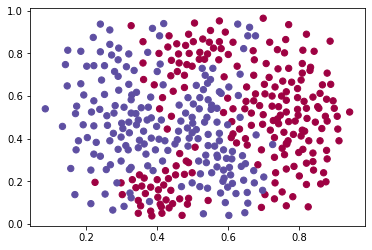

In [129]:
train_X = data_X[:-200]
train_Y = data_Y[:-200]

test_X = data_X[-200:]
test_Y = data_Y[-200:]

plt.scatter(data_X[:,0], data_X[:,1], c=data_Y, s=40, cmap=plt.cm.Spectral);

train_X = train_X.T
test_X = test_X.T

test_Y =  np.array([test_Y])
train_Y = np.array([train_Y])

print(f"Train X: {train_X.shape}, Train Y: {train_Y.shape}\n Test X: {test_X.shape},  Test Y: {test_Y.shape}")

## 2. Forward propagation

### 2.1 Linear forward (Perceptron)

<img src="./images/perceptron.png" style="width:400px;display:block;margin:auto">

The weighted sum can be presented as dot product of neuron inputs from previous layer and the connection weights plus bias. The vectorized formula looks like this:

$$W^TX + b$$

*Sometimes this equation is without transposing the matrices.*

Where **linear forward function** $Z$ for any layer looks like this:

$$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}$$


In [130]:
def linear_forward(A, W, b):
    Z = W.dot(A) + b
    cache = (A, W, b)
    return Z, cache

### 2.2 Linear activation functions:
There are many activation functions. For this case we are using two of them:
- **ReLU** (Rectified Linear Unit)
$$ReLU(Z) = max(0, Z)$$
- **Sigmoid**
$$\sigma(Z) = \frac{1}{ 1 + e^{-(Z)}}$$

<img src="./images/activation_functions.png" style="width:400px;display:block;margin:auto">

*Activation function tells the neuron to pass its value based on an activation threshold. It's a similar way of how neurons in brain passes the signals (residual networks goes a step further in that). If I have to explain this concept to my students without any knowledge what Perceptron algorithm is I like to explain it like "How much are we sure of something multiplied by how does it matter. If then, we think it's a dog than probably it's a dog." For example: to say something is a dog - the most important is if it's barking and has four legs rather than having a fur and a tail, most animals have them.*

<img src="./images/weights_explained.png" style="width:400px;display:block;margin:auto">


In [131]:
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z
    return A, cache


def sigmoid(Z):
    A = 1. / (1. + np.exp(-Z))
    cache = Z
    return A, cache

In [132]:
def linear_activation_forward(A_prev, W, b, activation):
    
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = activation(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

### 2.3 Forward propagation:
Forward propagation passes the input through the each hidden layer of a network, the last layer is responsible for output.

In [133]:
def forward_propagation(X, parameters):
    caches = []
    A = X
    layers_amount = len(parameters) // 2

    for l in range(1, layers_amount):
        A_prev = A

        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], relu)
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(layers_amount)], parameters['b' + str(layers_amount)], sigmoid)
    caches.append(cache)

    return AL, caches     

### 2.4 Loss function
A loss function is a measure of how well a machine learning model is performing on a given task during training. Cross-entropy cost function $J$ for a dataset with $m$ samples:

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$

*I'm adding an epsilon value to avoid zero log. Is it possible to do it in a different way?*

In [134]:
def compute_cost(AL, Y):  
    eps = 1e-8

    m = Y.shape[1]
    
    cost = -(1./m) * (np.dot(Y,np.log(AL + eps).T) + np.dot(1-Y, np.log(1-AL + eps).T))
    cost = np.squeeze(cost)
    
    return cost

## 3. Backward Propagation

### 3.1 Linear backward
Backpropagation is used to calcuate the gradient of the loss function with respect to the parameters. Using these gradients later to update parameters is a process where a network actually learns.

Backpropagation moves in opposite direction than forward propagation.

$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$

In [135]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = 1./m * np.dot(dZ, A_prev.T)
    db = 1./m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T,dZ)

    return dA_prev, dW, db

### 3.2 Backpropagation derivatives of relu and sigmoid functions:

$$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]})$$

In [136]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ


def sigmoid_backward(dA, cache):
    Z = cache
    s = 1. / (1+np.exp(-Z))
    dZ = dA  * s * (1.-s)
    return dZ

### 3.3 Backpropagation of linear activation

In [137]:
def linear_activation_backward(dA, cache, activation):
    
    linear_cache, activation_cache = cache
    dZ = activation(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

### 3.4 Backpropagation function

*I'm adding an epsilon value to avoid division by zero. Is it possible to do it in a different way?*

In [138]:
def backward_propagation(AL, Y, caches):

    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    eps = 1e-8

    dAL = - (np.divide(Y, AL + eps) - np.divide(1 - Y, 1 - AL + eps))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, sigmoid_backward)
    
    for l in reversed(range(L-1)):

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, relu_backward)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 3.5 Update parameters
Update parameters to minimalize the cost through the gradient descent algorithm where $\alpha$ is learning rate.

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}$$

In [ ]:
def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

## 4. Feedforward network model:

Feedforward network consists of input, hidden layers and output which will perform binary classification. It's the most basic network which consists of dense hidden layers similarly to Tensorflow.

<img src="./images/network.png" style="width:400px;display:block;margin:auto">

### 4.1 Create the model
For each layer from `layer_dimension`, create the corresponding values of weights and bias.

In [139]:
def create_model(layers_dimension):

    np.random.seed(1)

    parameters = {}
    layers_amount = len(layers_dimension)

    for l in range(1, layers_amount):

        random_weights = np.random.randn(layers_dimension[l], layers_dimension[l-1])

        parameters['W' + str(l)] = random_weights / np.sqrt(layers_dimension[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dimension[l],1))

    return parameters

### 4.2 Predict
Prediction in smple words predicts the classification by a single forward pass.

*I created an additional helper function to get the accuracy.*

In [141]:
def predict(X, parameters):

    y_prob, caches = forward_propagation(X, parameters)
    y_hat = np.zeros((1, X.shape[1]))

    for i in range(y_prob.shape[1]):
        y_hat[0,i] = 1 if y_prob[0,i] > 0.5 else 0

    return y_hat


def get_accuracy(X, y, parameters):
    p = predict(X, parameters)
    amount = X.shape[1]
    accuracy = np.sum(np.equal(p, y))
    
    return accuracy / amount

## 5. Create and train the model 

### 5.1 Define the model architecture
`create_model` function automatically initializes the hidden layers dimension and  weights.

**How do set the network's architecture?**

In `NEURAL_NETWORK_LAYERS_SIZE`:
- Elements in list are dense layers.
- Value is the number of neurons.

In [142]:
INPUT_SIZE = 2
NEURAL_NETWORK_LAYERS_SIZE = [INPUT_SIZE, 100, 75, 50, 1]

parameters = create_model(NEURAL_NETWORK_LAYERS_SIZE)

print("Neural network dimensions:")
for key, val in parameters.items():
    print(f"{key} {val.shape}")

Neural network dimensions:
W1 (100, 2)
b1 (100, 1)
W2 (75, 100)
b2 (75, 1)
W3 (50, 75)
b3 (50, 1)
W4 (1, 50)
b4 (1, 1)


### 5.2 Train the model

In [143]:
LEARNING_RATE = 0.5
EPOCHS = 3000

costs = []
accuracies = []

for epoch in range(0, EPOCHS):
    AL, caches = forward_propagation(train_X, parameters)
    grads = backward_propagation(AL, train_Y, caches)
    parameters = update_parameters(parameters, grads, LEARNING_RATE)

    cost = compute_cost(AL, train_Y)
    
    if epoch % 100 == 0:
        accuracy = get_accuracy(train_X, train_Y, parameters)
        print(f"Epoch {epoch} \tCost: {cost:.4f} \tAccuracy: {accuracy:.4f}")
        costs.append(cost)
        accuracies.append(accuracy)

train_accuracy = get_accuracy(train_X, train_Y, parameters)
test_accuracy = get_accuracy(test_X, test_Y, parameters)

print(f"\nTrain Accuracy: {train_accuracy:.4f} \t Test Accuracy: {test_accuracy:.4f}")

Epoch 0 	Cost: 0.6915 	Accuracy: 0.5481
Epoch 100 	Cost: 0.5354 	Accuracy: 0.6731
Epoch 200 	Cost: 0.5005 	Accuracy: 0.7163
Epoch 300 	Cost: 0.4217 	Accuracy: 0.8125
Epoch 400 	Cost: 0.4108 	Accuracy: 0.8413
Epoch 500 	Cost: 0.3779 	Accuracy: 0.8654
Epoch 600 	Cost: 0.4243 	Accuracy: 0.8365
Epoch 700 	Cost: 0.3665 	Accuracy: 0.8654
Epoch 800 	Cost: 0.2841 	Accuracy: 0.8990
Epoch 900 	Cost: 0.2843 	Accuracy: 0.8990
Epoch 1000 	Cost: 0.2630 	Accuracy: 0.8894
Epoch 1100 	Cost: 0.3058 	Accuracy: 0.8846
Epoch 1200 	Cost: 0.3402 	Accuracy: 0.8125
Epoch 1300 	Cost: 0.3131 	Accuracy: 0.8702
Epoch 1400 	Cost: 0.2746 	Accuracy: 0.8798
Epoch 1500 	Cost: 0.2089 	Accuracy: 0.9183
Epoch 1600 	Cost: 0.2324 	Accuracy: 0.8846
Epoch 1700 	Cost: 0.2317 	Accuracy: 0.8942
Epoch 1800 	Cost: 0.2599 	Accuracy: 0.8125
Epoch 1900 	Cost: 0.1934 	Accuracy: 0.9038
Epoch 2000 	Cost: 0.2927 	Accuracy: 0.7788
Epoch 2100 	Cost: 0.2400 	Accuracy: 0.8798
Epoch 2200 	Cost: 0.1804 	Accuracy: 0.9231
Epoch 2300 	Cost: 0.176

## 6. Evaluate

### 6.1 Accuracy and cost plot

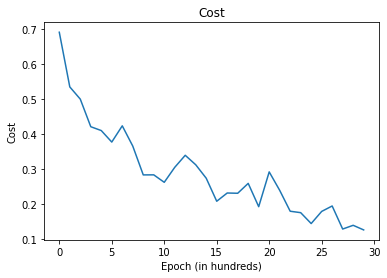

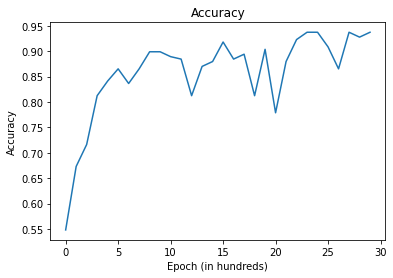

In [144]:
plt.plot(np.squeeze(costs))
plt.ylabel('Cost')
plt.xlabel('Epoch (in hundreds)')
plt.title("Cost")
plt.show()

plt.plot(accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Epoch (in hundreds)')
plt.title("Accuracy")
plt.show()

### 6.2 Analyze the results:
**If our team is red:**
- Our team have difficulties in the midfield.
- There is a significant gap between the wingers and line between defense and midfield.

**Network analysis and possible improvements:**
- It's possible to reach 95% accuracy.
- **Definitely we have a problem with overfitting** when we have 3 hidden layers.
- Why do we need high learning rate and number of epochs? **High learning rate hinders the model from covergence.** It causes spikes in accuracy. But on the other hand, how many epochs should such a basic task have? 

**TODO: Investigate possible improvements.**

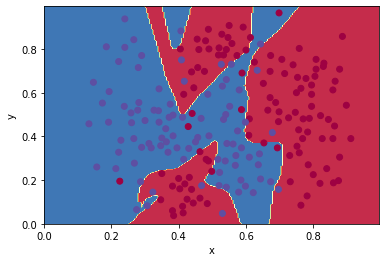

In [145]:
def plot_decision_boundary(model, X, y):
    h = 0.005
    x_min = 0
    x_max = 1
    y_min = 0
    y_max = 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

plot_decision_boundary(lambda x: predict(x.T, parameters), test_X, test_Y)